In [5]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from bdd100k.label.palette import get_palette
import json
from prettytable.prettytable import PrettyTable

from lib.data.tools import load_mmcv_checkpoint, load_checkpoint
from models.modelInterface import BDD100kModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


## Setting

In [3]:
config_file = "/home/zekun/drivable/src/models/config-deeplabv3plus-sem_seg.py"
checkpoint_file = "/home/zekun/drivable/outputs/semantic/db/models/model-20231005-131935.pth"
train_attr_file = "/home/zekun/drivable/data/bdd100k/labels/10k/bdd100k_labels_images_attributes_train.json"
val_attr_file = "/home/zekun/drivable/data/bdd100k/labels/10k/bdd100k_labels_images_attributes_val.json"

output_size = (512,1024)
num_classes = 20


## Show single image

In [2]:
image_name = "../data/bdd100k/images/100k/val/b1ceb32e-51852abe.jpg"

In [ ]:
backbone = load_mmcv_checkpoint(config_file)
load_checkpoint(backbone, checkpoint_file)

model = BDD100kModel(
    num_classes=num_classes,
    backbone=backbone,
    size=output_size
)
# model.to(DEVICE)
model.eval()

torch.Size([512, 1024])


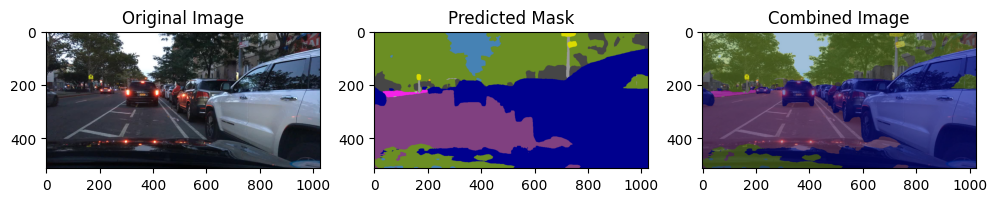

In [11]:
image_origin = Image.open(image_name)
image_origin = image_origin.resize((output_size[1], output_size[0]))
image_tensor = ToTensor()(image_origin)
# image_tensor = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor)
image_tensor = image_tensor.unsqueeze(0)
# image_tensor = image_tensor.to(DEVICE)

with torch.no_grad():
    output = model(image_tensor)
    # output = output.detach().cpu().numpy()
    output = torch.argmax(output, dim=1).squeeze().detach().cpu()
    print(output.shape)
pred_img_np = output.numpy().astype(np.int8)
pred_img = Image.new('P', (pred_img_np.shape[1], pred_img_np.shape[0]))
palettes = get_palette("sem_seg")
pred_img.putpalette(palettes)
pred_img.putdata(pred_img_np.ravel().tolist())
comb_img = Image.blend(image_origin, pred_img.convert("RGB"), alpha=0.5)

plt.figure(figsize=(12, 4))  
  
plt.subplot(1, 3, 1)  
plt.imshow(image_origin)  
plt.title('Original Image')

  
plt.subplot(1, 3, 2)  
plt.imshow(pred_img)  
plt.title('Predicted Mask')  
  
plt.subplot(1, 3, 3)  
plt.imshow(comb_img)  
plt.title('Combined Image')  

plt.savefig("ttt.jpg")
plt.show()


## check num of samples

In [33]:
cond_list = []

def extract_attr(attr_dict:dict):
        return [attr_dict["weather"], attr_dict["scene"], attr_dict["timeofday"]]

def comb_attr(attr_lst):
    return f"{attr_lst[0]}-{attr_lst[1]}-{attr_lst[2]}"

def split_attr(attr_s:str):
     return attr_s.split('-')

train_record_lst = {}
with open(train_attr_file, 'r') as f:
    attr_data = json.load(f)
    for entry in attr_data:
        attr = extract_attr(entry['attributes'])
        if len(cond_list) == 0 or attr in cond_list:
            k = comb_attr(attr)
            train_record_lst[k] = train_record_lst.get(k,0) + 1

val_record_lst = {}
with open(val_attr_file, 'r') as f:
    attr_data = json.load(f)
    for entry in attr_data:
        attr = extract_attr(entry['attributes'])
        if len(cond_list) == 0 or attr in cond_list:
            k = comb_attr(attr)
            val_record_lst[k] = val_record_lst.get(k,0) + 1

table = PrettyTable()
table.field_names = ['weather', 'scene', 'timeofday', 'train_samples', 'val_samples']

for k,v in train_record_lst.items():
    weather, scene, time = split_attr(k)
    v2 = val_record_lst.get(k,0)
    table.add_row([weather, scene, time, v, v2])

print(f"total conditions: {len(train_record_lst)}")

table.sortby = 'val_samples'
table.reversesort = True
print(table)


total conditions: 44
+---------------+-------------+-----------+---------------+-------------+
|    weather    |    scene    | timeofday | train_samples | val_samples |
+---------------+-------------+-----------+---------------+-------------+
|     clear     | city street |  daytime  |      1953     |     250     |
|    overcast   | city street |  daytime  |      1405     |     239     |
| partly cloudy | city street |  daytime  |      472      |      99     |
|     clear     |   highway   |  daytime  |      788      |      76     |
|     snowy     | city street |  daytime  |      398      |      74     |
|    overcast   |   highway   |  daytime  |      317      |      38     |
|    overcast   | residential |  daytime  |      138      |      35     |
|     clear     | residential |  daytime  |      168      |      27     |
|     rainy     | city street |  daytime  |      200      |      24     |
|     clear     | city street |   night   |      215      |      23     |
| partly cloudy |